# Pneumonia Diagnosis Algorithm
### by Eddie Diaz

## Chosen Dataset
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Preparation

For this lab, I chose to work with image data from X-Ray scans that have been used in pneumonia diagnosis. I will use Tensorflow and Keras to create a convolutional neural network that will identify whether a patient is infected or healthy. Due to the nature of this data, the resulting model needs to perform exceedingly well (99%), and false negatives are very important to minimize. We do not want to feign healthy lungs when a patient has a lung infection. To get started lets load our images and format them to equal sizes.



Working with 1583 healthy images
Image examples: 
NORMAL2-IM-0875-0001.jpeg


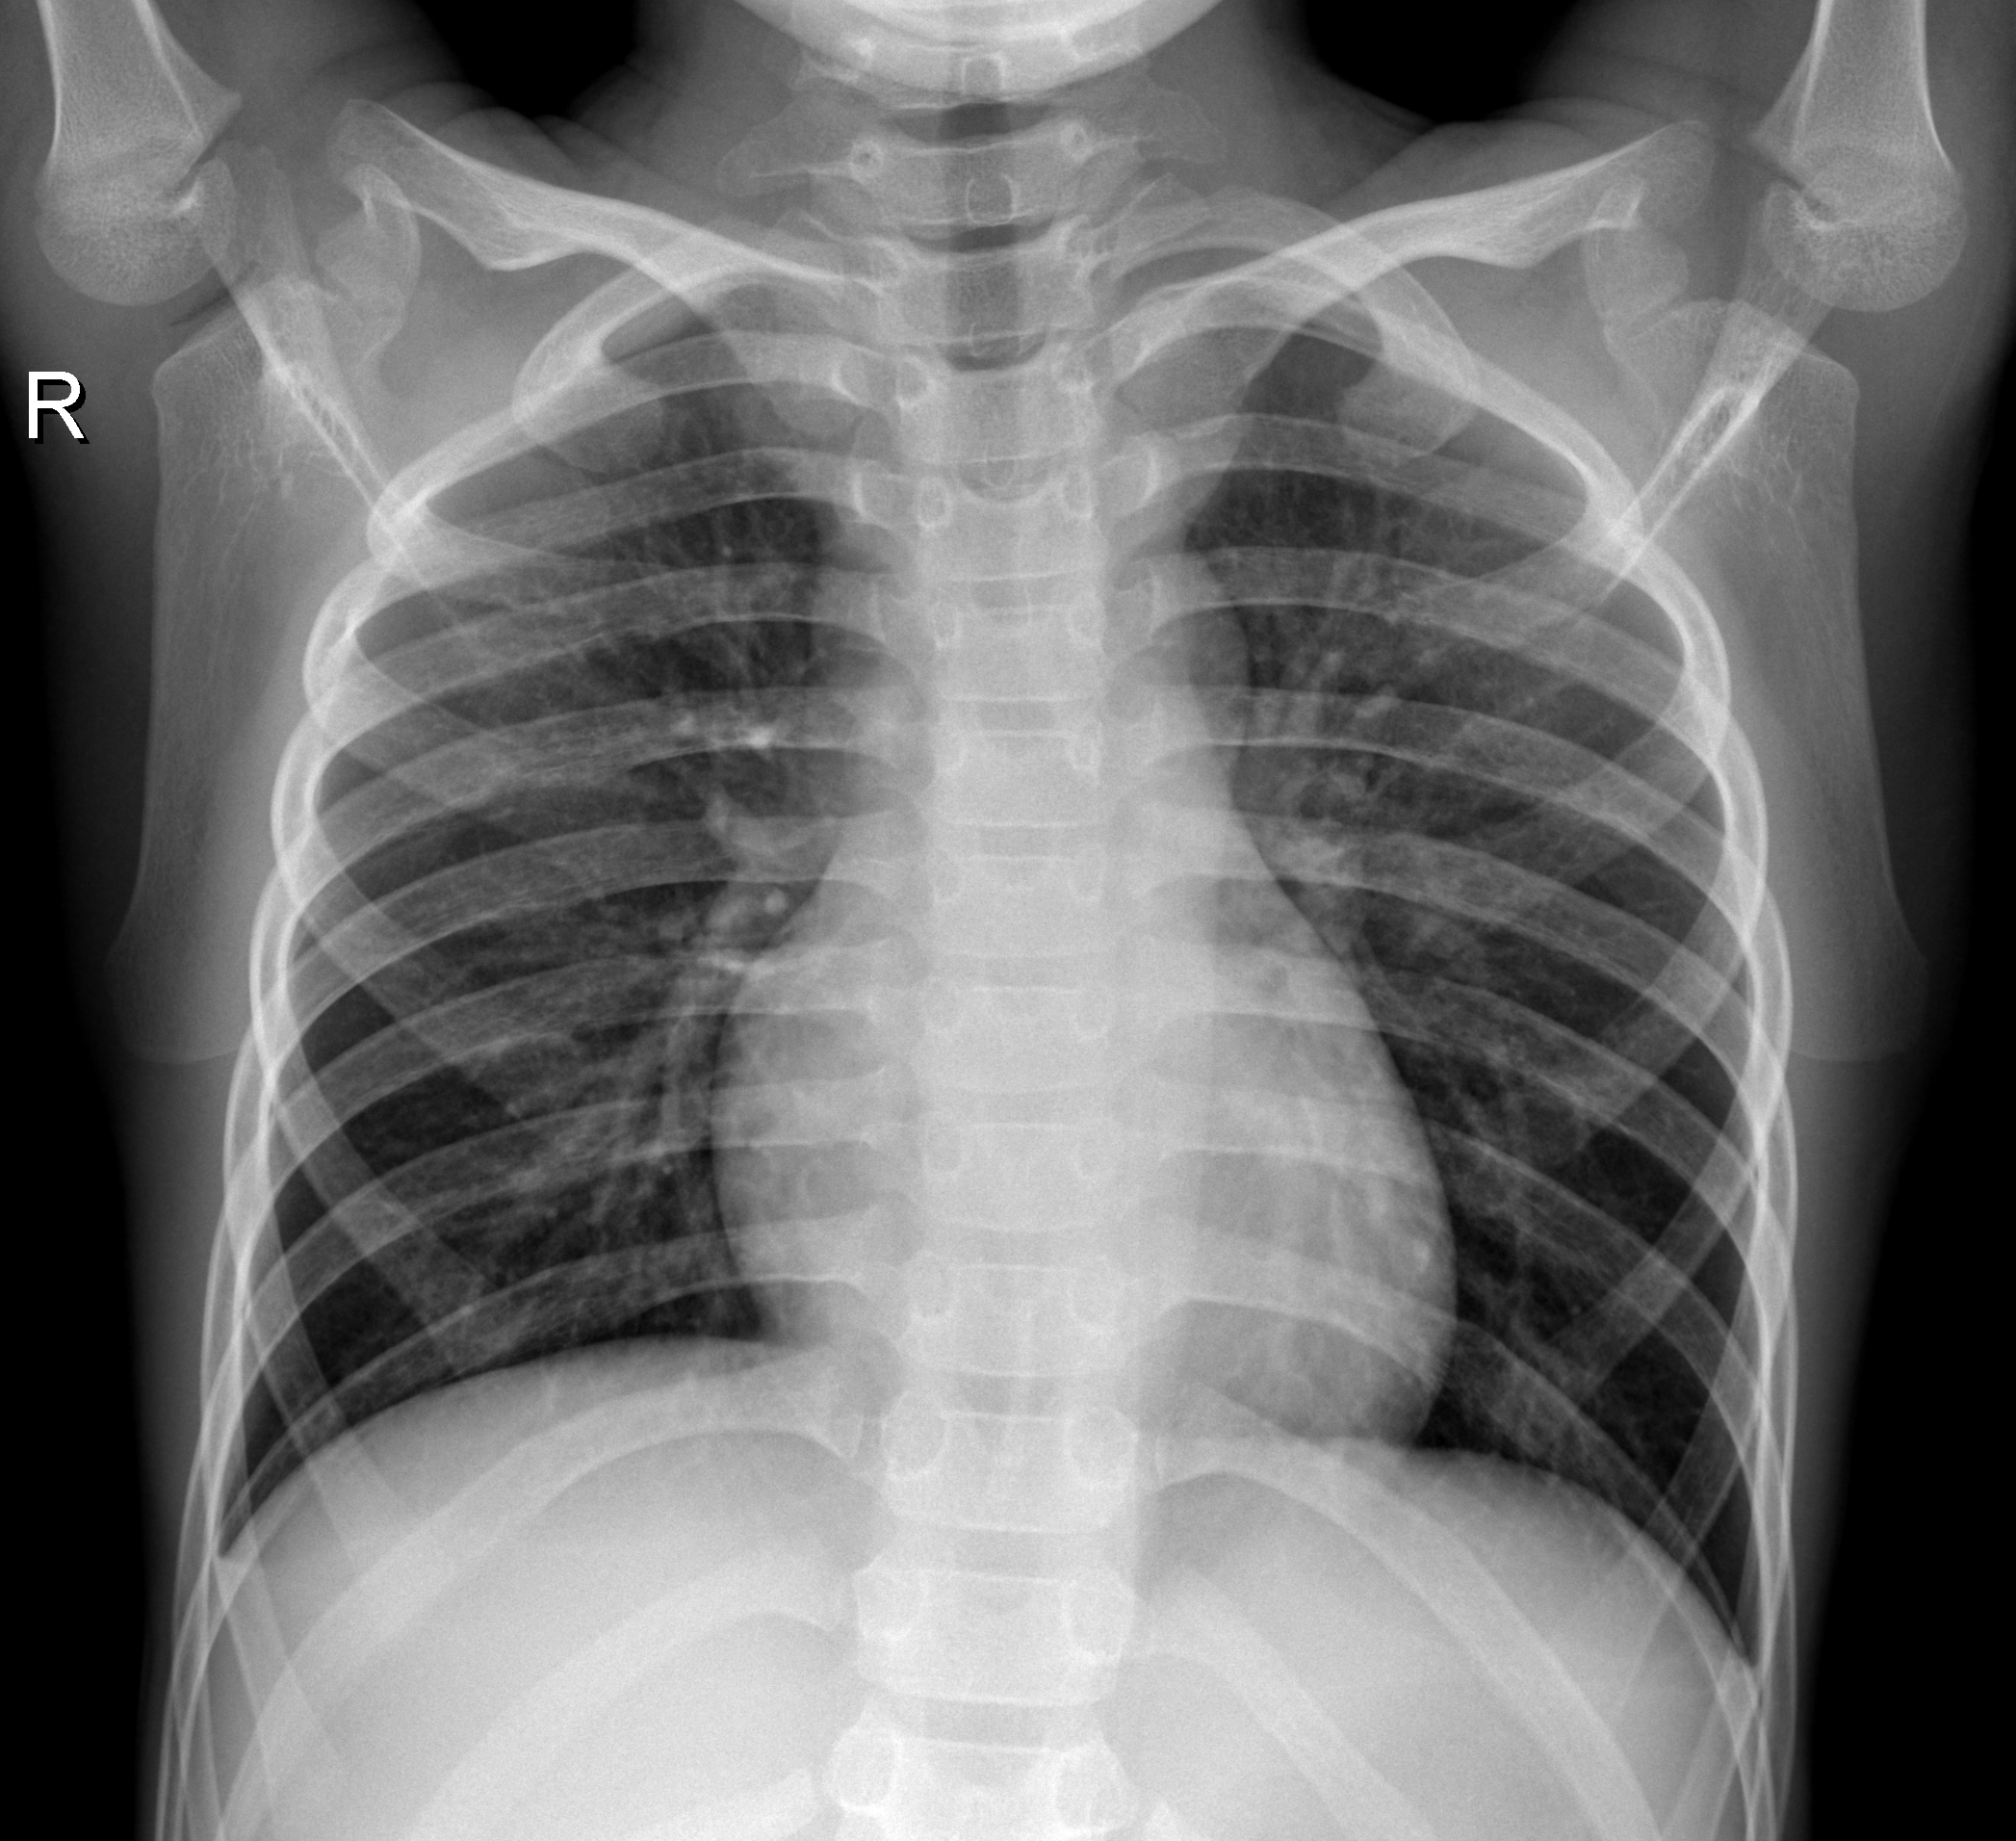

Working with 4273 infections
Image examples: 
person505_virus_1017.jpeg


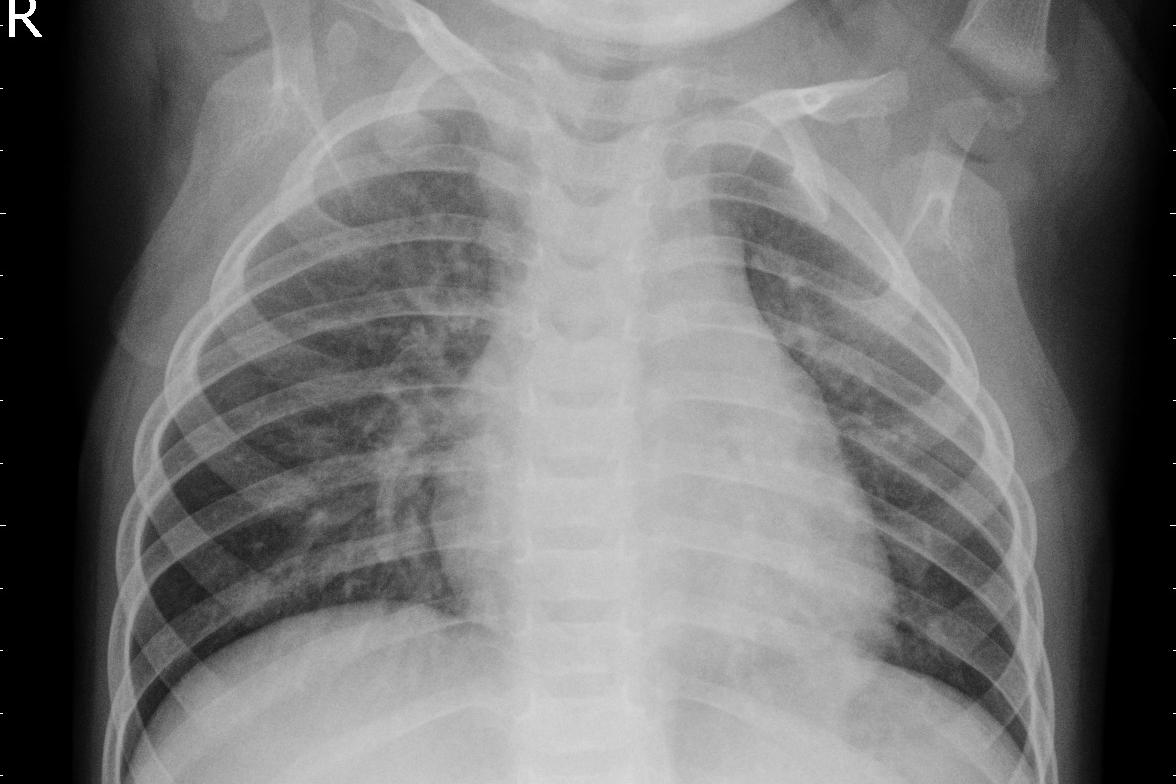

In [ ]:
# code recycled from lab 2

import numpy as np
import pandas as pd
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

normal_folder = "./dataset/NORMAL"
infected_folder = "./dataset/PNEUMONIA"

normal_files = [f for f in os.listdir(normal_folder) if os.path.isfile(os.path.join(normal_folder, f))]

print("Working with {0} healthy images".format(len(normal_files)))
print("Image examples: ")

for i in range(40, 41):
    print(normal_files[i])
    display(_Imgdis(filename=normal_folder + "/" + normal_files[i], width=240, height=320))
    
infected_files = [f for f in os.listdir(infected_folder) if os.path.isfile(os.path.join(infected_folder, f))]

print("Working with {0} infections".format(len(infected_files)))
print("Image examples: ")

for i in range(40, 41):
    print(infected_files[i])
    display(_Imgdis(filename=infected_folder + "/" + infected_files[i], width=240, height=320))

Awesome, the images are loaded. Now I will reformat the .jpeg files to a standard size of 250 by 250. To do this, I used the pillow library's thumbnail method, which preserves the original image's proportions so that no important details are lost. I will create two new directories for normal and infected lungs respectively, and each will contain the resized images.

In [ ]:
# custom algorithm that resizes images and saves the smaller version in a new directory.

def resize_images(input_folder, output_folder, target_size=(256, 256)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.jpeg'):
            input_file_path = os.path.join(input_folder, filename)
            output_file_path = os.path.join(output_folder, filename)

            with Image.open(input_file_path) as img:
                img.thumbnail(target_size, Image.ANTIALIAS)
                img.save(output_file_path)

normal_resize = "./dataset/normal_resize/"
target_size = (150, 150)

resize_images(normal_folder, normal_resize, target_size)

/var/folders/s3/j5z935293gb554y0mbshh4n00000gn/T/ipykernel_13094/276983492.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)


In [ ]:
# same thing as above, but for the infected folder. These will be crucial to set our target later.

def resize_images(input_folder, output_folder, target_size=(150, 150)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.jpeg'):
            input_file_path = os.path.join(input_folder, filename)
            output_file_path = os.path.join(output_folder, filename)

            with Image.open(input_file_path) as img:
                img.thumbnail(target_size, Image.ANTIALIAS)
                img.save(output_file_path)

infected_resize = "./dataset/infected_resize/"

resize_images(infected_folder, infected_resize, target_size)

/var/folders/s3/j5z935293gb554y0mbshh4n00000gn/T/ipykernel_13094/95078271.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)


Now that our images are all the same size, we can import them into a pandas dataframe. Here, the binary classification of infected or not infected will be hardcoded into the target value, which our machine will later attempt to predict.

                                          image_data  target
1  [[25, 27, 29, 29, 28, 28, 28, 29, 29, 29, 29, ...       0
2  [[108, 54, 59, 47, 52, 87, 79, 84, 96, 98, 101...       0
3  [[44, 54, 67, 78, 84, 90, 95, 98, 109, 97, 168...       0
4  [[2, 6, 14, 25, 37, 45, 49, 51, 63, 67, 72, 77...       0
5  [[110, 119, 122, 122, 126, 132, 160, 199, 168,...       0
Dataframe contains 5856 images
target
1    4273
0    1583
Name: count, dtype: int64


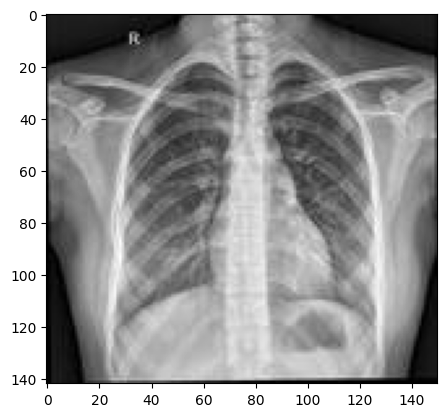

In [ ]:
# code recycled and improved from lab 2.

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

images = pd.DataFrame(columns=["image_data", "target"])
id = 0

# import healthy lung images as numpy arrays into  pandas dataframe
for file in os.listdir(normal_resize):
    id += 1
    img = imread(os.path.join(normal_resize, file))
    img = img.astype(np.uint8)
    images.loc[id] = {"image_data": img, "target": 0}    

# import infected lung images as numpy arrays into  pandas dataframe
for file in os.listdir(infected_resize):
    id += 1
    img = imread(os.path.join(infected_resize, file))
    img = img.astype(np.uint8)
    images.loc[id] = {"image_data": img, "target": 1}    

print(images.head())


print("Dataframe contains {0} images".format(len(images.index)))
print(images['target'].value_counts())

plt.imshow(images.iloc[0]["image_data"], cmap='gray')


In [ ]:
images['image_data'].apply(lambda x: str(x.tolist())).to_csv('image_data.csv', index=False, header=['image_data'])
images['target'].to_csv('target.csv', index=False, header=['target'])

Because me Mac is incompatible with Tensorflow, I exported the data to csv files that will allow me to continue modeling on Goggle Collab. With images loaded as table data, we can now create the model. However, we first need to lay some groundwork.

### Performance Metric of Choice — Recall

Because our model will be used to diagnose patients with pneumonia, false negatives are particularly concerning. These instances occur when the model fails to identify a patient with pneumonia, potentially leading to a lack of proper treatment and severe health consequences. For this reason, the best metric to quantify performance is recall.

Recall is defined as the proportion of true positive instances out of the total positive instances. By focusing on recall, the model's performance is evaluated on its ability to correctly identify pneumonia cases. High recall indicates a low number of false negatives and signals the majority of pneumonia cases are detected. This performance is crucial for our model so that patients and treated treated and cured. In prioritizing recall, the algorithm is designed to minimize the risk of undiagnosed pneumonia cases.

The cost associated with false negatives in medical diagnosis is often much higher than that of false positives. A false negative can result in delayed or missed treatment, leading to severe health complications and even death. Compared to other metrics, recall  is the most appropriate for this specific problem. Accuracy may be misleading in cases of imbalanced datasets or when the cost of false negatives is much higher than that of false positives. Precision focuses on minimizing false positives but may not adequately address the issue of false negatives. F1-score balances both precision and recall, but in this scenario, minimizing false negatives is more critical, making Recall the better choice. Therefore, this model's focus on recall helps to ensure that the final model is better suited for its intended purpose, which is to diagnose pneumonia effectively and minimize the risk of false negatives.

![Alt text](1_7J08ekAwupLBegeUI8muHA.png)

### Train/Test Split Method — Stratified 5-fold Cross-Validation

Earlier, we noted this dataset is relatively small, containing 5856 images. In addition, the dataset is skewed toward positive cases of pneumonia, as the overall ratio for infected-to-healthy is 4273 to 1583. Because of this small size and imbalance, we can best split our data into training and testing sets, using stratified 5-fold cross-validation. With a small dataset, using a larger number of folds could result in a limited number of samples in each fold, so five smaller sets of over 1000 images each sounds more reasonable. Additionally, this method ensures that the same proportion of infected and healthy scans is maintained within each fold, preventing any single split from having a significantly different class distribution than others, which could negatively impact model performance. 

I believe the K-Fold method best mirrors real-world medical diagnosis scenarios, which present new patients with varying proportions of infected and healthy cases. Stratified K-fold cross-validation simulates this situation by ensuring that the class distribution in each fold remains consistent, providing a more realistic evaluation of the model's performance. By using different combinations of training and validation sets, this method allows for better assessment of the model's generalization capabilities, which is important when diagnosing medical conditions using limited and imbalanced datasets.

Lastly, I do not believe it's worth mixing K-Fold with other methods for this project. The small dataset size prefers a simple approach to prevent over-fitting and preserve class distribution. Integrating a shuffle split could lead to an overly optimistic estimate of the model's performance and reduce generalization capabilities when encountering new data. This does not seem optimal for the use case, which should be as consistent as an evidence-based medical evaluation.

To implement the stratified 5-fold split, I will first define the CNN models and implement the split with each new architecture. The reason for this solution is that a K-Fold split will alter the shape of our input and cause trouble for the model. However, by integrating the model into our split and training/testing with each fold, we can run the models while obtaining the same results.

### Data Augmentation — Image Generator

Although I personally do not think computer generated images should be used for healthcare tasks, data expansion is a requirement for this lab. While I prefer to keep medical data to what's biologically accurate, these methods can make certain phenomena more apparent for machine-learning diagnosis. To augment the dataset at hand, I chose the Keras ImageDataGenerator during preprocessing for it's simplicity. To do this, we simply import the dependency and create a data generator.

Of note, I will omit the use of flipping in this generator, as it is known to cause trouble in chest X-Ray scans by altering the location of vital organs, such as the heart.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.1,
                              fill_mode='nearest')

## Modeling

To begin modeling, we first import the needed dependencies, and ensure our GPU is connected.

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model
from tensorflow.keras.models import clone_model
from tensorflow.keras.metrics import Recall

keras.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Now, we must re-import the data so that I may complete the lab online using Google Collab. Again, this is due to my new Mac Silicon's incompatibility with tensorflow.

In [3]:
import pandas as pd
import numpy as np

# Due to my Mac's compatibility issues, I created the following algorithm to re-import the table data inside Goggle Collab.
image_data = np.load('./image_data.npy', allow_pickle=True)
target = np.load('./target.npy')

images = pd.DataFrame({'image_data': image_data, 'target': target})

print(images.head())

                                          image_data  target
0  [[28, 28, 28, 28, 28, 28, 28, 28, 30, 30, 29, ...       0
1  [[85, 56, 52, 74, 88, 94, 101, 104, 114, 138, ...       0
2  [[38, 68, 77, 82, 97, 97, 118, 172, 157, 136, ...       0
3  [[2, 11, 26, 40, 47, 54, 66, 79, 81, 79, 91, 1...       0
4  [[117, 117, 127, 134, 162, 180, 165, 166, 165,...       0


Now, we can set our X and y. I kept running into errors because the images were formated differently from the source. With the help of ChatGPT, I was able to convert my images to a standard, grayscale, and float32 NumPy array that can be processed by Tensorflow.

In [4]:
from PIL import Image

target_size = (100, 100)

# custom formatting algorithm for X and y
image_data_list = [np.array(Image.fromarray(img).convert('L').resize(target_size)) for img in images['image_data']]
X = np.stack(image_data_list, axis=0)
X = X / 255.0
X = X.astype('float32')

y = images['target'].to_numpy()

Now we can set some general parameters. These can be modified for later architectures, but some arguments, like NUM_CLASSES should stay consistent to reflect the task at hand. Also, I decided to limit the epochs to 5, because we already have a five-fold split, so our model will be running a total of 25 times.

In [5]:
img_wh = 100
NUM_CLASSES = 2  
n_splits = 5
epochs = 5 
batch_size = 32

### Model 1

The first convolutional neural network I created contains an input layer for our formatted images (100, 100, 1). Three convolutional layers with increasing filters by a factor of 2; these layers all use ReLu activation and maintain a consistent kernel size of 3x3. Each convolutional layer is followed by a max-pooling layer that reduces dimensions using 2x2 windows. After these, our network contains a flattening layer and a dense layer, which also contains a relu activation and 128 matching the number of filters at the last convolutional layer. Then, I added a deopout layer to prevent overfitting at each fold or epoch. Finally, the output layer uses the sigmoid activation function and only ontains one unit for a final diagnosis. 

The model is compiled using the Adam optimizer, with a binary cross-entropy loss function for binary classification and the recall metric for evaluation, as discussed above.

In [7]:
def model_1():
    cnn = Sequential()
    cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_wh, img_wh, 1)))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()]) 
    return cnn

Epoch 1/5
146/146 [==============================] - 8s 43ms/step - loss: 0.4974 - recall_1: 0.9396 - val_loss: 0.2498 - val_recall_1: 0.8749
Epoch 2/5
146/146 [==============================] - 7s 46ms/step - loss: 0.3068 - recall_1: 0.9207 - val_loss: 0.2174 - val_recall_1: 0.9216
Epoch 3/5
146/146 [==============================] - 5s 35ms/step - loss: 0.2775 - recall_1: 0.9324 - val_loss: 0.1938 - val_recall_1: 0.9275
Epoch 4/5
146/146 [==============================] - 6s 44ms/step - loss: 0.2413 - recall_1: 0.9363 - val_loss: 0.1557 - val_recall_1: 0.9778
Epoch 5/5
37/37 [==============================] - 0s 5ms/step - loss: 0.1379 - recall_1: 0.9637
Loss: 0.1379326730966568, Recall: 0.9637426733970642
Epoch 1/5
146/146 [==============================] - 9s 42ms/step - loss: 0.5130 - recall_2: 0.9517 - val_loss: 0.4164 - val_recall_2: 0.7787
Epoch 2/5
146/146 [==============================] - 5s 37ms/step - loss: 0.3636 - recall_2: 0.9097 - val_loss: 0.2072 - val_recall_2: 0.960

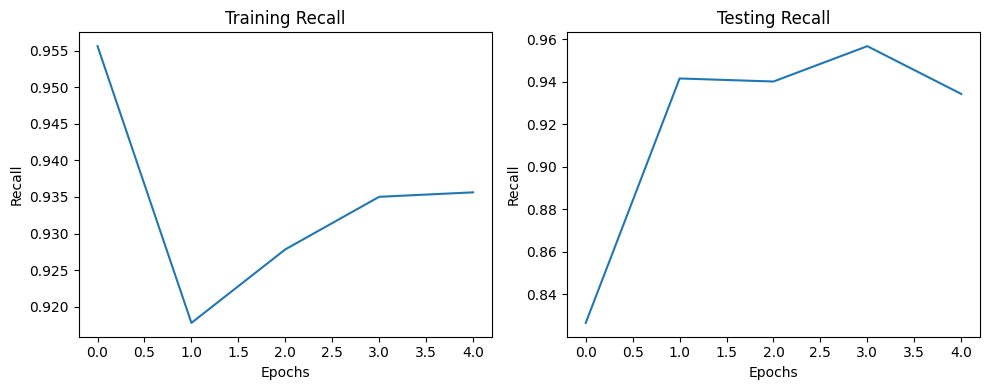

In [9]:
# this code is custom, inspired from Dr. Larson's notebook 12 but largely my own. I embedded the modeling into my skf split loop

from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt

# split algorithm adapted from Dr. Larson's notebooks and earlier classwork.
skf = StratifiedKFold(n_splits=5)

# save results into empty arrays for visualization and analysis
train_recalls = []
val_recalls = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # model integrated into the for loop
    model = model_1()

    train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_test, y_test))

    # recall keys use the fold variable in the runtime environment, this can track recall and allow us to obtain overall results
    train_recall_key = f'recall_{fold + 1}'
    val_recall_key = f'val_recall_{fold + 1}'

    # append results to arrays for analysis and visualization
    train_recalls.append(history.history[train_recall_key])
    val_recalls.append(history.history[val_recall_key])

    loss, recall = model.evaluate(X_test, y_test)
    print("Loss: {}, Recall: {}".format(loss, recall))

mean_train_recall = np.mean(train_recalls, axis=0)
mean_val_recall = np.mean(val_recalls, axis=0)

plt.figure(figsize=(10, 4))

# Training plot
plt.subplot(1, 2, 1)
plt.plot(mean_train_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Training Recall')

# Testing plot
plt.subplot(1, 2, 2)
plt.plot(mean_val_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Testing Recall')

# Display the plots
plt.tight_layout()
plt.show()

In [13]:
print("Average Training Recall:", np.mean(mean_train_recall))
print("Average Testing Recall:", np.mean(mean_val_recall))

Average Training Recall: 0.9343738126754759
Average Testing Recall: 0.9198191714286803


I'm very pleased with these results. 92% recall is very good for a first run. Notably, my testing run without data augmentation actually obtained better results (96%), as in the results for the first fold. Nevertheless, this model should contain at least 99% recall if it were to be used in healthcare, as we do not want to misdiagnose any patients. In an effort to obtain better results, we will train a new model with updated parameters.

## Model 2

Our second model keeps the same architecture as the first but changes its parameters to better analyze X-Ray scans. The changes made are as follows:

Kernel Size Variation: Adjusting to larger or smaller kernels can help the model capture either more global or fine details, respectively. This model starts with a smaller kernel size (3x3) in the first convolutional layer to capture finer details. Then, a larger kernel size (5x5) in the second convolutional layer to capture more global features. Lastly, we return to a smaller kernel size (3x3) again to capture more localized information.

Dense Layer Units: I increased the number of units in the dense layer to 256 to allow the model to learn more complex representations of the X-Ray scans provided.

In [14]:
def model_2():
    cnn = Sequential()
    cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_wh, img_wh, 1)))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid')) 
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    return cnn

Epoch 1/5
146/146 [==============================] - 8s 39ms/step - loss: 0.5068 - recall_9: 0.9546 - val_loss: 0.3434 - val_recall_9: 0.8023
Epoch 2/5
146/146 [==============================] - 5s 37ms/step - loss: 0.3336 - recall_9: 0.9179 - val_loss: 0.3255 - val_recall_9: 0.7918
Epoch 3/5
146/146 [==============================] - 5s 33ms/step - loss: 0.2968 - recall_9: 0.9228 - val_loss: 0.2081 - val_recall_9: 0.9205
Epoch 4/5
146/146 [==============================] - 7s 48ms/step - loss: 0.2628 - recall_9: 0.9320 - val_loss: 0.1835 - val_recall_9: 0.9099
Epoch 5/5
37/37 [==============================] - 0s 5ms/step - loss: 0.1599 - recall_9: 0.9614
Loss: 0.15989843010902405, Recall: 0.961403489112854
Epoch 1/5
146/146 [==============================] - 9s 38ms/step - loss: 0.4964 - recall_10: 0.9508 - val_loss: 0.2211 - val_recall_10: 0.9707
Epoch 2/5
146/146 [==============================] - 6s 42ms/step - loss: 0.3021 - recall_10: 0.9196 - val_loss: 0.2192 - val_recall_10: 0

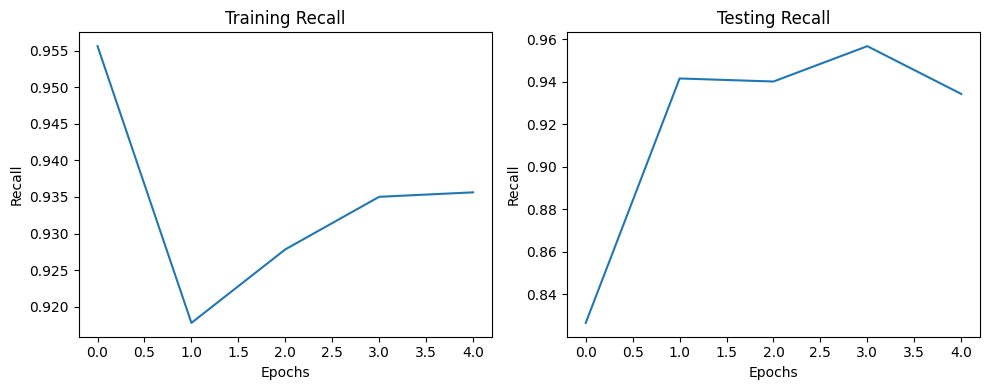

Average Training Recall: 0.9352336645126342
Average Testing Recall: 0.9174891924858093


In [18]:
# new empty arrays to avoid overlap
train_recalls_2 = []
val_recalls_2 = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # changed to new model
    model = model_2()

    train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_test, y_test))

    # +9 looks weird, but it allows my code to keep up with the runtime environment variable under the hood, note keys in results above
    train_recall_key = f'recall_{fold + 9}'
    val_recall_key = f'val_recall_{fold + 9}'

    train_recalls_2.append(history.history[train_recall_key])
    val_recalls_2.append(history.history[val_recall_key])

    loss, recall = model.evaluate(X_test, y_test)
    print("Loss: {}, Recall: {}".format(loss, recall))

mean_train_recall_2 = np.mean(train_recalls_2, axis=0)
mean_val_recall_2 = np.mean(val_recalls_2, axis=0)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(mean_train_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Training Recall')

plt.subplot(1, 2, 2)
plt.plot(mean_val_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Testing Recall')

plt.tight_layout()
plt.show()

print("Average Training Recall:", np.mean(mean_train_recall_2))
print("Average Testing Recall:", np.mean(mean_val_recall_2))

Overall, this model saw a slight improvement over model 1 for training, but not for testing. However, despite the drop in the performance average, there were now two folds that contained a recal over 95%. Perhaps the data augmentation and the kernel sizes modify the image too much, clouding the results for this task. For our next model, we will change the actual architecture for better results.

### Model 3

This model contains an additional convolutional and max pooling layer, but the kernel sizes are consistent 3x3 again. In addition to the larger amounts of filters, these changes may enable the machine to capture more complex features. We enhanced this model's capabilities by adding an additional dense layer that will more effectively reduce these complexities to a binary classification. Finally, we included another dropout layer to prevent overfitting.

In [19]:
def model_3():
    cnn = Sequential()
    cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_wh, img_wh, 1), padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid')) 
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    return cnn

Epoch 1/5
146/146 [==============================] - 11s 49ms/step - loss: 0.5633 - recall_14: 0.9717 - val_loss: 0.4599 - val_recall_14: 0.9006
Epoch 2/5
146/146 [==============================] - 6s 39ms/step - loss: 0.4657 - recall_14: 0.9216 - val_loss: 0.3400 - val_recall_14: 0.8012
Epoch 3/5
146/146 [==============================] - 6s 42ms/step - loss: 0.3327 - recall_14: 0.9255 - val_loss: 0.1819 - val_recall_14: 0.9462
Epoch 4/5
146/146 [==============================] - 6s 42ms/step - loss: 0.2656 - recall_14: 0.9316 - val_loss: 0.1719 - val_recall_14: 0.9497
Epoch 5/5
37/37 [==============================] - 0s 11ms/step - loss: 0.1380 - recall_14: 0.9462
Loss: 0.13796302676200867, Recall: 0.9461988210678101
Epoch 1/5
146/146 [==============================] - 10s 45ms/step - loss: 0.5637 - recall_15: 0.9670 - val_loss: 0.4546 - val_recall_15: 0.9941
Epoch 2/5
146/146 [==============================] - 7s 45ms/step - loss: 0.4377 - recall_15: 0.8979 - val_loss: 0.4452 - val

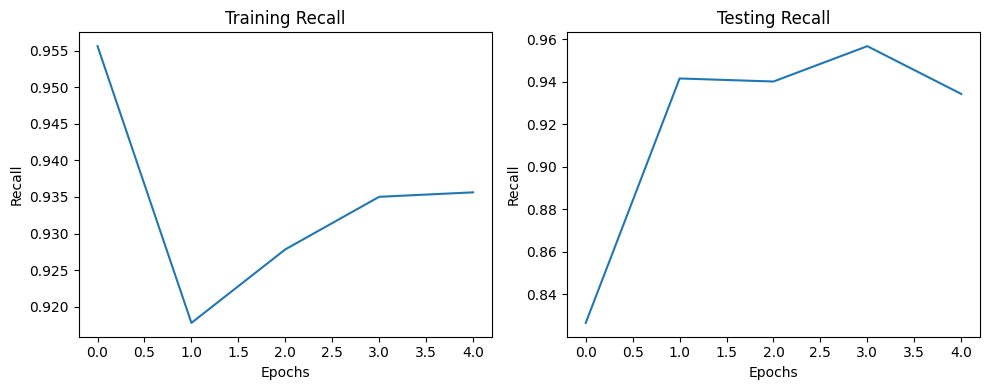

Average Training Recall: 0.9330175065994263
Average Testing Recall: 0.8974054241180418


In [20]:
# new empty arrays to avoid overlap
train_recalls_3 = []
val_recalls_3 = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # changed to new model
    model = model_3()

    train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_test, y_test))

    # 14 is the next recall key from the above results
    train_recall_key = f'recall_{fold + 14}'
    val_recall_key = f'val_recall_{fold + 14}'

    train_recalls_3.append(history.history[train_recall_key])
    val_recalls_3.append(history.history[val_recall_key])

    loss, recall = model.evaluate(X_test, y_test)
    print("Loss: {}, Recall: {}".format(loss, recall))

mean_train_recall_3 = np.mean(train_recalls_3, axis=0)
mean_val_recall_3 = np.mean(val_recalls_3, axis=0)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(mean_train_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Training Recall')

plt.subplot(1, 2, 2)
plt.plot(mean_val_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Testing Recall')

plt.tight_layout()
plt.show()

print("Average Training Recall:", np.mean(mean_train_recall_3))
print("Average Testing Recall:", np.mean(mean_val_recall_3))

Ouch. These results were not what I expected. Again, the complexity of the calculations in the above network may have overcomplicated the task. In addition, the consistent kernel sizes may have prevented the machine from generalizing or fine-tuning the complex details it is meant to capture. However, the third fold of this model contains the best results we have obtained in any fold so far, and this model also has two folds with recall values over 95%. Perhaps changing the kernel sizes inside the new architecture will improve our performance.

## Model 4

This model's changes are simple. The first two convolutional layers contain larger kernels for more generalized features to be captured from the outset. Then, we returen to a 3x3 kernel size to capture finer details in the final layers. The rest of the model is largely the same.

In [21]:
def model_4():
    cnn = Sequential()
    cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(img_wh, img_wh, 1), padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(512, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid')) 
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    return cnn

Epoch 1/5
146/146 [==============================] - 9s 46ms/step - loss: 0.5528 - recall_22: 0.9487 - val_loss: 0.4308 - val_recall_22: 0.8292
Epoch 2/5
146/146 [==============================] - 9s 58ms/step - loss: 0.4483 - recall_22: 0.9083 - val_loss: 0.4776 - val_recall_22: 0.6737
Epoch 3/5
146/146 [==============================] - 9s 63ms/step - loss: 0.3822 - recall_22: 0.9058 - val_loss: 0.2614 - val_recall_22: 0.8830
Epoch 4/5
146/146 [==============================] - 9s 61ms/step - loss: 0.2727 - recall_22: 0.9311 - val_loss: 0.2035 - val_recall_22: 0.9731
Epoch 5/5
37/37 [==============================] - 0s 11ms/step - loss: 0.1711 - recall_22: 0.9614
Loss: 0.17112524807453156, Recall: 0.961403489112854
Epoch 1/5
146/146 [==============================] - 12s 61ms/step - loss: 0.5447 - recall_23: 0.9626 - val_loss: 0.3269 - val_recall_23: 0.8548
Epoch 2/5
146/146 [==============================] - 9s 60ms/step - loss: 0.4234 - recall_23: 0.9135 - val_loss: 0.3227 - val_r

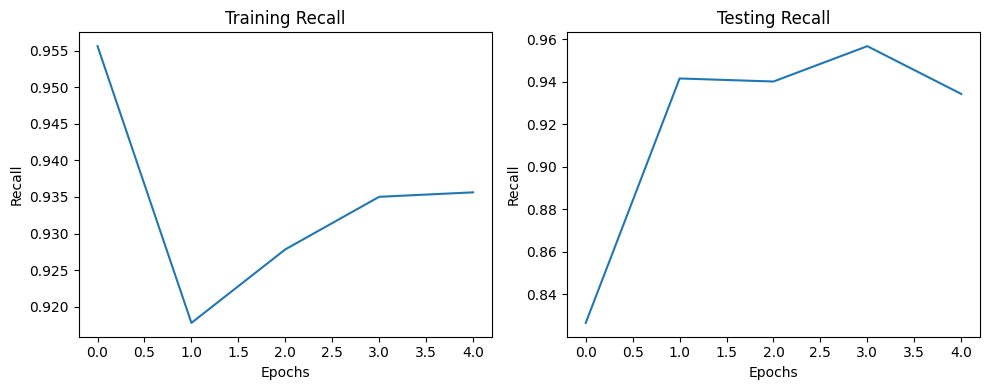

Average Training Recall: 0.9297417759895324
Average Testing Recall: 0.8769106435775758


In [25]:
# new empty arrays to avoid overlap
train_recalls_4 = []
val_recalls_4 = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # changed to new model
    model = model_4()

    train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_test, y_test))

    # 22 is next due to some errors in running the code
    train_recall_key = f'recall_{fold + 22}'
    val_recall_key = f'val_recall_{fold + 22}'

    train_recalls_4.append(history.history[train_recall_key])
    val_recalls_4.append(history.history[val_recall_key])

    loss, recall = model.evaluate(X_test, y_test)
    print("Loss: {}, Recall: {}".format(loss, recall))

mean_train_recall_4 = np.mean(train_recalls_4, axis=0)
mean_val_recall_4 = np.mean(val_recalls_4, axis=0)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(mean_train_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Training Recall')

plt.subplot(1, 2, 2)
plt.plot(mean_val_recall)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Testing Recall')

plt.tight_layout()
plt.show()

print("Average Training Recall:", np.mean(mean_train_recall_4))
print("Average Testing Recall:", np.mean(mean_val_recall_4))

From these results, it truly seems like our model does not like the added complexity, and the same issues present in model 2 also seem true here. Unfortunately, model 4 exhibits the worst results we have obtained so far. One final thing to try, let's see if pre-trained weights give us an edge.

### Pre-Training Comparison

To potentially improve results, we can use a pre-trained model such as MobileNetV2. To do this, we need to import the required dependencies, define the new model structure with the pretrained base, and format our inputs to fit the 3-layer requirement (not grayscale). Although I could have chosen a more robust model like the ImageNet VGG16, I decided to use MobileNet because it's very simple to integrate and requires minimal image formatting.

Epoch 1/5
146/146 [==============================] - 17s 93ms/step - loss: 0.4032 - recall_6: 0.9122 - val_loss: 0.1815 - val_recall_6: 0.9333
Epoch 2/5
146/146 [==============================] - 13s 87ms/step - loss: 0.2225 - recall_6: 0.9446 - val_loss: 0.1684 - val_recall_6: 0.9462
Epoch 3/5
146/146 [==============================] - 14s 94ms/step - loss: 0.1982 - recall_6: 0.9508 - val_loss: 0.1894 - val_recall_6: 0.9216
Epoch 4/5
146/146 [==============================] - 13s 86ms/step - loss: 0.1837 - recall_6: 0.9546 - val_loss: 0.1820 - val_recall_6: 0.9251
Epoch 5/5
37/37 [==============================] - 1s 19ms/step - loss: 0.1744 - recall_6: 0.9240
Loss: 0.17441758513450623, Recall: 0.9239766001701355


Epoch 1/5
146/146 [==============================] - 18s 95ms/step - loss: 0.3814 - recall_7: 0.9120 - val_loss: 0.1631 - val_recall_7: 0.9520
Epoch 2/5
146/146 [==============================] - 13s 86ms/step - loss: 0.2233 - recall_7: 0.9393 - val_loss: 0.1903 - val_recall_7: 0.9016
Epoch 3/5
146/146 [==============================] - 13s 88ms/step - loss: 0.2088 - recall_7: 0.9411 - val_loss: 0.2151 - val_recall_7: 0.8876
Epoch 4/5
146/146 [==============================] - 13s 86ms/step - loss: 0.1992 - recall_7: 0.9485 - val_loss: 0.1436 - val_recall_7: 0.9719
Epoch 5/5
37/37 [==============================] - 1s 18ms/step - loss: 0.1710 - recall_7: 0.9192
Loss: 0.17095467448234558, Recall: 0.9192037582397461


Epoch 1/5
146/146 [==============================] - 17s 94ms/step - loss: 0.4320 - recall_8: 0.9064 - val_loss: 0.2257 - val_recall_8: 0.8864
Epoch 2/5
146/146 [==============================] - 12s 85ms/step - loss: 0.2159 - recall_8: 0.9455 - val_loss: 0.1613 - val_recall_8: 0.9379
Epoch 3/5
146/146 [==============================] - 14s 94ms/step - loss: 0.2082 - recall_8: 0.9469 - val_loss: 0.2574 - val_recall_8: 0.8536
Epoch 4/5
146/146 [==============================] - 12s 83ms/step - loss: 0.2035 - recall_8: 0.9479 - val_loss: 0.1676 - val_recall_8: 0.9813
Epoch 5/5
37/37 [==============================] - 1s 15ms/step - loss: 0.2390 - recall_8: 0.8782
Loss: 0.23895381391048431, Recall: 0.8782201409339905


Epoch 1/5
146/146 [==============================] - 17s 93ms/step - loss: 0.4093 - recall_9: 0.9075 - val_loss: 0.1717 - val_recall_9: 0.9497
Epoch 2/5
146/146 [==============================] - 13s 86ms/step - loss: 0.2162 - recall_9: 0.9443 - val_loss: 0.1730 - val_recall_9: 0.9181
Epoch 3/5
146/146 [==============================] - 13s 87ms/step - loss: 0.1996 - recall_9: 0.9487 - val_loss: 0.1876 - val_recall_9: 0.9310
Epoch 4/5
146/146 [==============================] - 12s 84ms/step - loss: 0.1834 - recall_9: 0.9547 - val_loss: 0.1318 - val_recall_9: 0.9626
Epoch 5/5
37/37 [==============================] - 1s 15ms/step - loss: 0.1466 - recall_9: 0.9614
Loss: 0.1466038078069687, Recall: 0.961403489112854


Epoch 1/5
146/146 [==============================] - 18s 93ms/step - loss: 0.5145 - recall_10: 0.8996 - val_loss: 0.2333 - val_recall_10: 0.9135
Epoch 2/5
146/146 [==============================] - 12s 85ms/step - loss: 0.2171 - recall_10: 0.9476 - val_loss: 0.2786 - val_recall_10: 0.8632
Epoch 3/5
146/146 [==============================] - 12s 85ms/step - loss: 0.2080 - recall_10: 0.9473 - val_loss: 0.2676 - val_recall_10: 0.8772
Epoch 4/5
146/146 [==============================] - 14s 95ms/step - loss: 0.1926 - recall_10: 0.9514 - val_loss: 0.1608 - val_recall_10: 0.9567
Epoch 5/5
37/37 [==============================] - 1s 15ms/step - loss: 0.1780 - recall_10: 0.9298
Loss: 0.17795659601688385, Recall: 0.9298245906829834


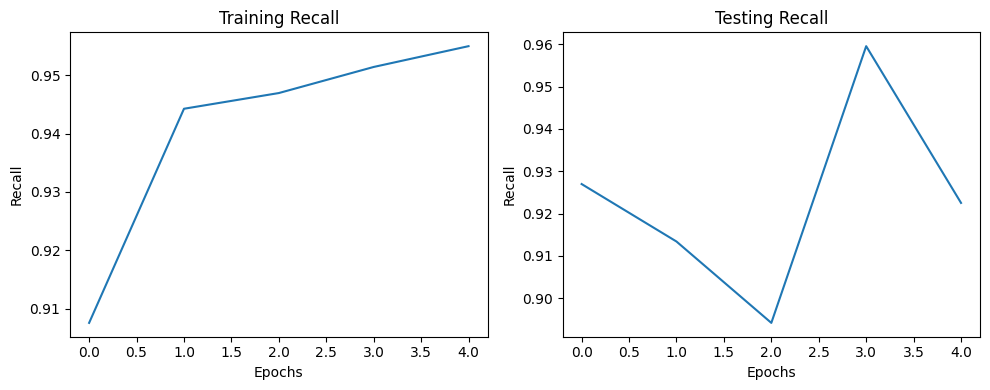

Average Training Recall: 0.9410287904739381
Average Testing Recall: 0.9233295822143555


In [9]:
from tensorflow.keras.applications import MobileNetV2
import cv2
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt

skf = StratifiedKFold(n_splits=5)

def pretrained_model(img_wh=100):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_wh, img_wh, 3)))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    return model


train_recalls_5 = []
val_recalls_5 = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Convert grayscale to 3-channel images for pre-training
    X_train_3channel = np.repeat(X_train, 3, axis=-1)
    X_test_3channel = np.repeat(X_test, 3, axis=-1)

    # I reset my runtime and messed up the first try, so the key is now 6
    train_recall_key = f'recall_{fold + 6}'
    val_recall_key = f'val_recall_{fold + 6}'

    model = pretrained_model()

    train_generator = data_gen.flow(X_train_3channel, y_train, batch_size=batch_size)
    X_test_3channel_resized = np.array([cv2.resize(img, (img_wh, img_wh)) for img in X_test_3channel])
    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_test_3channel, y_test))

    loss, recall = model.evaluate(X_test_3channel, y_test)
    train_recalls_5.append(history.history[train_recall_key])
    val_recalls_5.append(history.history[val_recall_key])
    print("Loss: {}, Recall: {}".format(loss, recall))
    
mean_train_recall_5 = np.mean(train_recalls_5, axis=0)
mean_val_recall_5 = np.mean(val_recalls_5, axis=0)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(mean_train_recall_5)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Training Recall')

plt.subplot(1, 2, 2)
plt.plot(mean_val_recall_5)
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Testing Recall')

plt.tight_layout()
plt.show()

print("Average Training Recall:", np.mean(mean_train_recall_5))
print("Average Testing Recall:", np.mean(mean_val_recall_5))

The addition of a pre-trained base model greatly improved both training and testing results. The addition of 2% more recall is significant, especially for the training score. Also, compared to the other models, the individual fold scores are much more stable. For these reasons, if I were to improve my model for field deployment, these techniques seem like a must.

### MLP Comparison

Our final task in this lab is to compare a CNN model to a standard Multi-Layer Preceptron. To do this, we will create a simple MLP using keras. This model will be compared to our Model 1 from this lab, as it obatined the best results without external resources. After we train and evaluate both models, we will calculate the reciever operating characteristic, and track the area under the curve for each fold and epoch. These will be appended to an empty array for each respective model. After all epochs are through, we can calcuplate the mean AUC for both models, and compare them using a paired t-test, which will give us a P-value for statistical analysis.

In [26]:
from sklearn.metrics import roc_curve, auc
from scipy.stats import ttest_rel

# Create a simple MLP using keras
def create_mlp_model():
    model = Sequential()
    model.add(Flatten(input_shape=(img_wh, img_wh, 1)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    return model

# Initialize AUC lists as empty arrays for later testing
auc_list_cnn = []
auc_list_mlp = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Train and evaluate CNN model 1
    model_cnn = model_1()
    model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    cnn_preds = model_cnn.predict(X_test).ravel()

    # Train and evaluate the MLP
    model_mlp = create_mlp_model()
    model_mlp.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    mlp_preds = model_mlp.predict(X_test).ravel()

    # Calculate ROC and AUC for each model
    fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_preds)
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_preds)
    auc_cnn = auc(fpr_cnn, tpr_cnn)
    auc_mlp = auc(fpr_mlp, tpr_mlp)

    auc_list_cnn.append(auc_cnn)
    auc_list_mlp.append(auc_mlp)

# Calculate mean AUC for each model
mean_auc_cnn = np.mean(auc_list_cnn)
mean_auc_mlp = np.mean(auc_list_mlp)
print("Mean AUC (CNN): {:.4f}".format(mean_auc_cnn))
print("Mean AUC (MLP): {:.4f}".format(mean_auc_mlp))

# Perform a paired t-test to compare the AUCs
t_stat, p_value = ttest_rel(auc_list_cnn, auc_list_mlp)
print("Paired t-test p-value: {:.4f}".format(p_value))

Epoch 1/5
147/147 [==============================] - 4s 16ms/step - loss: 0.3769 - recall_27: 0.9447 - val_loss: 0.2900 - val_recall_27: 0.9906
Epoch 2/5
147/147 [==============================] - 2s 13ms/step - loss: 0.2257 - recall_27: 0.9456 - val_loss: 0.1713 - val_recall_27: 0.9801
Epoch 3/5
147/147 [==============================] - 2s 12ms/step - loss: 0.1780 - recall_27: 0.9599 - val_loss: 0.1409 - val_recall_27: 0.9591
Epoch 4/5
147/147 [==============================] - 2s 12ms/step - loss: 0.1699 - recall_27: 0.9587 - val_loss: 0.1429 - val_recall_27: 0.9789
Epoch 5/5
37/37 [==============================] - 0s 3ms/step
Epoch 1/5
147/147 [==============================] - 2s 7ms/step - loss: 1.0063 - recall_28: 0.8663 - val_loss: 0.2814 - val_recall_28: 0.9743
Epoch 2/5
147/147 [==============================] - 1s 7ms/step - loss: 0.4137 - recall_28: 0.8660 - val_loss: 0.3128 - val_recall_28: 0.9509
Epoch 3/5
147/147 [==============================] - 1s 7ms/step - loss: 0.

Because this p-value is under .05, we conlclude the difference in performance is statistically significant. The CNN is much better suited to analyze the X-Ray Image Dataset.